In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from tensorflow_probability import distributions as tfd

from datetime import datetime

from utils import *

In [2]:
mnist = tf.keras.datasets.mnist


In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [21]:
tf.reset_default_graph()


In [22]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=1.0):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [23]:
n_z = 2
n_class = 10
batchsize = 64

X = tf.placeholder(tf.float32, shape=[None, 784])
X_reshape = tf.reshape(X, [-1, 28,28,1])
label = tf.placeholder(tf.int32, shape=[None])
label_oh = tf.one_hot(label, 10)

# ENCODER
def encoder(x):
    with tf.variable_scope("encoder"):
        h1 = lrelu(conv2d(x, 1, 16, "d_h1")) # 28x28x1 -> 14x14x16
        h2 = lrelu(conv2d(h1, 16, 32, "d_h2")) # 14x14x16 -> 7x7x32
        h2_flat = tf.reshape(h2,[-1, 7*7*32])
        
        class_ = tf.nn.softmax(dense(h2_flat, 7*7*32, n_class, "w_class"))
        class_ = tfd.Categorical(probs=class_)
        
        w_mean = dense(h2_flat, 7*7*32, n_z, "w_mean")
        w_stddev = tf.nn.softplus(dense(h2_flat, 7*7*32, n_z, "w_stddev"))
        posterior = tfd.MultivariateNormalDiag(w_mean, w_stddev)
    return posterior, class_


# DECODER
# def decoder(z, class_):
#     with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
#         z = tf.concat([z, class_], axis=1)
#         z = tf.layers.dense(z, n_z, activation = tf.nn.relu)
#         z_develop = tf.layers.dense(z, 7*7*32, activation = tf.nn.relu)
#         z_matrix = tf.reshape(z_develop, [-1, 7, 7, 32])
#         h1 = tf.nn.relu(conv_transpose(z_matrix, [batchsize, 14, 14, 16], "g_h1"))
#         flat_dim = 16
#         h1_flat = tf.reshape(h1, [batchsize,14*14,flat_dim])
#         class_ = tf.stack([class_ for i in range(14*14)], axis=-2)
#         h1_flat = tf.concat([h1_flat, class_], axis=-1)
#         h1_flat = tf.layers.dense(h1_flat, flat_dim, activation = tf.nn.relu )
#         h1_flat = tf.layers.dense(h1_flat, flat_dim, activation = tf.nn.relu )
#         h1 = tf.reshape(h1_flat, [batchsize, 14, 14, 16])
#         h2 = conv_transpose(h1, [batchsize, 28, 28, 1], "g_h2")
#         h2 = tf.nn.sigmoid(h2)
#         h2 = tf.reshape(h2, [-1, 784])
#         dec = tfd.Bernoulli(probs=h2 + 1e-8)
#         dec = tfd.Independent(
#             distribution=dec,
#             reinterpreted_batch_ndims=1,
#             )
#     return dec, h2



# DECODER
def decoder(z, class_):
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
        z = tf.concat([z, class_], axis=1)
#         z = tf.layers.dense(z, n_z, activation = tf.nn.relu)
        z_develop = tf.layers.dense(z, 7*7*32, activation = tf.nn.relu)
        z_matrix = tf.nn.relu(tf.reshape(z_develop, [-1, 7, 7, 32]))
        h1 = tf.nn.relu(conv_transpose(z_matrix, [batchsize, 14, 14, 16], "g_h1"))
        h2 = conv_transpose(h1, [batchsize, 28, 28, 1], "g_h2")
        h2 = tf.nn.sigmoid(h2)
        h2 = tf.reshape(h2, [-1, 784])
        dec = tfd.Bernoulli(probs=h2 + 1e-8)
        dec = tfd.Independent(
            distribution=dec,
            reinterpreted_batch_ndims=1,
            )
    return dec, h2

prior = tfd.MultivariateNormalDiag(tf.zeros(n_z), tf.ones(n_z))

# ENCODER
posterior, class_ = encoder(X_reshape)
class_sampled = tf.one_hot(class_.sample(), 10)
code = posterior.sample()
struct_loss = tf.reduce_sum((-1)*label_oh*tf.log(class_.probs+1e-8), axis=1)

# DECODER
dec, generated_flat = decoder(code, class_sampled)
sampled_flat = dec.sample()
generated_images = tf.reshape(generated_flat, [-1, 28,28,1])
sampled_images = tf.reshape(sampled_flat, [-1, 28,28,1])

# LOSS
# latent_likelihood = prior.log_prob(code)
lambda_ = 500
alpha_ = 1
divergence = compute_mmd(code, prior.sample(200)) * (lambda_+alpha_-1)
div2 = tfd.kl_divergence(posterior, prior) * (1-alpha_)
likelihood = dec.log_prob(X)
elbo = likelihood - divergence - div2
cost = tf.reduce_mean(-elbo + struct_loss)

# likelihood = dec.log_prob(X) #dec.log_prob(X)/784
# divergence = tfd.kl_divergence(posterior, prior) * n_z
# elbo = likelihood - divergence #tf.reduce_mean(likelihood - divergence)
# cost = tf.reduce_mean(-elbo + struct_loss)

# TRAIN
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [24]:
# MANIPULATE
class_choice = tf.placeholder(tf.int32, shape=[None])
class_choice_oh = tf.one_hot(class_choice, 10)
_, generated_flat_choice = decoder(code, class_choice_oh)
generated_images_choice = tf.reshape(generated_flat_choice, [-1, 28,28,1])

In [25]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [26]:
# ITERATOR
all_nums = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(lambda x,y: (tf.reshape(x,[784])/255,y))
it = all_nums.batch(batchsize).repeat().make_initializable_iterator()
nb = it.get_next()
sess.run(it.initializer)

single_num_ds = {}
sn_iterators = {}
next_batch = {}
for i in range(10):
    print(i)
    single_num_ds[i] = all_nums.filter(lambda x,y: tf.equal(y,i)).batch(batchsize).repeat()
    sn_iterators[i] = single_num_ds[i].make_initializable_iterator()
    next_batch[i] = sn_iterators[i].get_next()
    sess.run(sn_iterators[i].initializer)

next_batch[10] = nb

0
1
2
3
4
5
6
7
8
9


In [27]:
mb_size = batchsize
for it in range(500):
    for i in range(11):
        X_mb, Y_mb = sess.run(next_batch[i])
#         X_mb, Y_mb = sess.run(nb)
        if len(X_mb)!=batchsize:
            continue
        _, c, l, d, s = sess.run((optimizer, cost, likelihood, divergence, struct_loss), 
                                         feed_dict={X: X_mb, label: Y_mb})
    
    now = datetime.now()
    if it % 10 == 0:
        print('Iter: {}'.format(it))
        print('cost: {:.4}'. format(np.mean(c)))
        print('likelihood: {:.4}'. format(np.mean(l)))
        print('divergence: {:.4}'. format(np.mean(d)))
        print('struct loss: {:.4}'. format(np.mean(s)))
        print(str(datetime.now()))
        print()
        


Iter: 0
cost: 543.5
likelihood: -535.3
divergence: 5.94
struct loss: 2.29
2019-05-19 19:33:53.212283

Iter: 10
cost: 224.5
likelihood: -216.4
divergence: 5.922
struct loss: 2.208
2019-05-19 19:34:01.674383

Iter: 20
cost: 223.0
likelihood: -212.4
divergence: 8.457
struct loss: 2.163
2019-05-19 19:34:10.413625

Iter: 30
cost: 215.8
likelihood: -211.0
divergence: 2.827
struct loss: 2.004
2019-05-19 19:34:20.036966

Iter: 40
cost: 206.9
likelihood: -204.0
divergence: 1.073
struct loss: 1.768
2019-05-19 19:34:28.691142

Iter: 50
cost: 194.7
likelihood: -191.4
divergence: 1.681
struct loss: 1.582
2019-05-19 19:34:37.290510

Iter: 60
cost: 198.8
likelihood: -193.6
divergence: 4.055
struct loss: 1.155
2019-05-19 19:34:45.469321

Iter: 70
cost: 215.6
likelihood: -207.8
divergence: 6.768
struct loss: 0.9561
2019-05-19 19:34:53.436896

Iter: 80
cost: 207.3
likelihood: -200.9
divergence: 5.244
struct loss: 1.182
2019-05-19 19:35:01.752847

Iter: 90
cost: 191.6
likelihood: -184.5
divergence: 6.16


In [29]:
b = tfd.Bernoulli(probs=[0.0,0.1,0.5,0.9,1.0])

In [33]:
sess.run(b.log_prob(tf.zeros_like(b.probs)))

array([        nan, -0.10536051, -0.6931472 , -2.302585  ,         nan],
      dtype=float32)

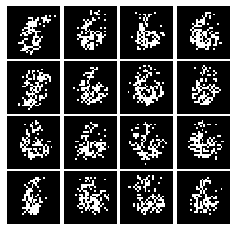

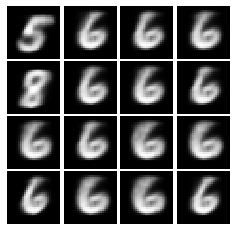

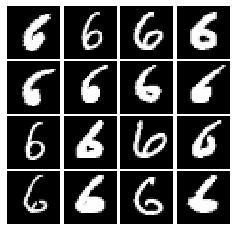

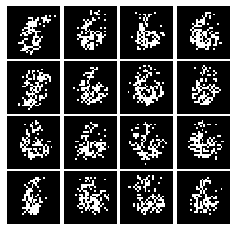

In [19]:
X_mb, _ = sess.run(next_batch[6])
g, s, r, z = sess.run([generated_images, sampled_images, X_reshape, code], feed_dict={X: X_mb})
plot(g)
plot(r)
plot(s)

In [12]:
sess.run(class_sampled, feed_dict = {X:X_mb})

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

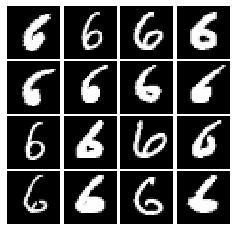

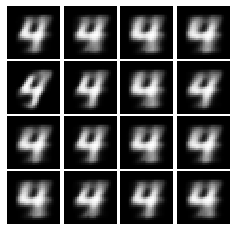

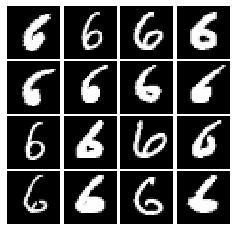

In [20]:
plot(sess.run(generated_images_choice, feed_dict = {X:X_mb, class_choice:[4 for i in range(batchsize)]}))
plot(X_mb)

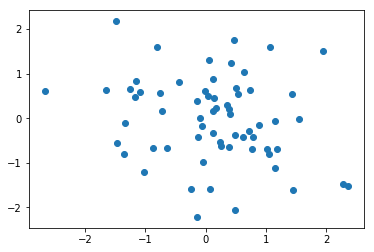

In [14]:
X_mb, _ = sess.run(next_batch[0])

code_ = sess.run(code, feed_dict = {X:X_mb})
plt.scatter(code_[:,0], code_[:,1])

In [15]:
code_

array([[ 1.4323791 ,  0.5493384 ],
       [ 0.4177424 ,  1.23837   ],
       [-1.0895845 ,  0.5885465 ],
       [-0.2473825 , -1.5768383 ],
       [-2.6707997 ,  0.60925376],
       [ 0.4960201 , -2.0499144 ],
       [ 0.23898607, -0.5320336 ],
       [ 0.3878539 ,  0.199806  ],
       [-1.1693001 ,  0.47773808],
       [-0.12556611, -0.42275462],
       [ 0.07684992, -1.5957688 ],
       [ 0.03418589,  0.50058514],
       [-1.259268  ,  0.66579574],
       [ 1.1540529 , -1.1129338 ],
       [-0.7517873 ,  0.5641264 ],
       [-0.0465472 , -0.972018  ],
       [-1.3598051 , -0.7936935 ],
       [-0.43605807,  0.8018391 ],
       [-0.15045361, -2.2217283 ],
       [-0.00598818,  0.6041402 ],
       [ 0.12239957,  0.16961358],
       [ 1.0672094 ,  1.6073895 ],
       [ 1.446433  , -1.6122272 ],
       [ 0.048282  ,  1.3096932 ],
       [ 0.4914089 , -0.36764657],
       [ 0.7123165 , -0.2797388 ],
       [ 0.8833003 , -0.16033536],
       [ 1.1883371 , -0.68947136],
       [ 0.77454305,